In [1]:
ls

sample_data/


In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd ..

/


In [ ]:
cd content

/content


In [ ]:
ls

drive/  sample_data/


In [ ]:
ls

bin@                        dev/     lib32@   NGC-DL-CONTAINER-LICENSE  root/  tmp/
boot/                       etc/     lib64@   opt/                      run/   tools/
content/                    home/    libx32@  proc/                     sbin@  usr/
cuda-keyring_1.0-1_all.deb  kaggle/  media/   python-apt/               srv/   var/
datalab/                    lib@     mnt/     python-apt.tar.xz*        sys/


In [ ]:
cd drive/MyDrive/Translation/

/content/drive/MyDrive/Translation


In [ ]:
!pip install boto3

mbart_train.py

In [ ]:
!pip install transformers datasets sacrebleu torch sentencepiece


In [ ]:
ls

drive/  sample_data/


In [ ]:
cd drive/MyDrive/Translation

/content/drive/MyDrive/Translation


In [ ]:
ls

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
ls: cannot open directory '.': No such file or directory


In [ ]:
pip show sacrebleu


Name: sacrebleu
Version: 2.5.1
Summary: Hassle-free computation of shareable, comparable, and reproducible BLEU, chrF, and TER scores
Home-page: 
Author: 
Author-email: Matt Post <post@cs.jhu.edu>
License: Apache License
                           Version 2.0, January 2004
                        http://www.apache.org/licenses/

   TERMS AND CONDITIONS FOR USE, REPRODUCTION, AND DISTRIBUTION

   1. Definitions.

      "License" shall mean the terms and conditions for use, reproduction,
      and distribution as defined by Sections 1 through 9 of this document.

      "Licensor" shall mean the copyright owner or entity authorized by
      the copyright owner that is granting the License.

      "Legal Entity" shall mean the union of the acting entity and all
      other entities that control, are controlled by, or are under common
      control with that entity. For the purposes of this definition,
      "control" means (i) the power, direct or indirect, to cause the
      direction or 

In [ ]:
import nltk
nltk.download('wordnet')



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
pip install nltk


In [ ]:
cd ..

/content/drive/MyDrive/Translation


In [ ]:


%%writefile mbart_train.py

import os
import argparse
import torch
import random
import numpy as np
import json

from datasets import Dataset, DatasetDict
from transformers import (
    MBartForConditionalGeneration,
    MBart50TokenizerFast,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    DataCollatorForSeq2Seq,
    EarlyStoppingCallback,
    TrainerCallback
)

# We keep sacrebleu for BLEU & CHRF
from sacrebleu.metrics import BLEU, CHRF

# NLTK for METEOR
import nltk
from nltk.translate.meteor_score import meteor_score


# ----------------------------------------
# Custom Callback for Logging Evaluation Metrics
# ----------------------------------------
class CustomLogCallback(TrainerCallback):
    """Logs metrics to a local JSON file after each evaluation."""
    def __init__(self, output_path="metrics_history.json"):
        super().__init__()
        self.output_path = output_path
        self.metrics_history = []

    def on_evaluate(self, args, state, control, **kwargs):
        """Called after each evaluation phase."""
        metrics = kwargs.get("metrics", {})
        current_epoch = state.epoch

        # We'll store only eval_ metrics and the epoch
        log_entry = {"epoch": current_epoch}
        for k, v in metrics.items():
            if k.startswith("eval_"):
                log_entry[k] = v

        self.metrics_history.append(log_entry)

    def on_train_end(self, args, state, control, **kwargs):
        """Called at the very end of training."""
        with open(self.output_path, "w") as f:
            json.dump(self.metrics_history, f, indent=2)


def main(args):
    # Decide on the device
    device = "cuda" if torch.cuda.is_available() and args.device == "cuda" else "cpu"

    # Create saved_model_directory if it doesn't exist
    if not os.path.exists(args.saved_model_directory):
        os.makedirs(args.saved_model_directory)

    # Load the mBART model and MBart50TokenizerFast
    model_name = args.model_name_or_path
    tokenizer = MBart50TokenizerFast.from_pretrained(model_name)
    model = MBartForConditionalGeneration.from_pretrained(model_name).to(device)

    # Use en_XX for English and xh_ZA for Ju/'hoansi (placeholder)
    src_lang = "en_XX"
    tgt_lang = "xh_ZA"
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang

    # Load data from english.txt and juhoansi.txt
    english_file = os.path.join(args.data_directory, "english.txt")
    juhoansi_file = os.path.join(args.data_directory, "juhoansi.txt")

    if not os.path.exists(english_file) or not os.path.exists(juhoansi_file):
        raise FileNotFoundError("Both english.txt and juhoansi.txt must exist in the data directory.")

    with open(english_file, encoding="utf-8") as f_en:
        en_lines = [l.strip() for l in f_en.readlines() if l.strip()]
    with open(juhoansi_file, encoding="utf-8") as f_ju:
        ju_lines = [l_ju.strip() for l_ju in f_ju.readlines() if l_ju.strip()]

    if len(en_lines) != len(ju_lines):
        raise ValueError("The number of lines in english.txt and juhoansi.txt must be the same.")

    # Combine and shuffle
    data_pairs = list(zip(en_lines, ju_lines))
    random.shuffle(data_pairs)

    # Split into train/val/test (70/15/15)
    total = len(data_pairs)
    train_size = int(0.7 * total)
    val_size = int(0.15 * total)
    test_size = total - train_size - val_size

    train_data = data_pairs[:train_size]
    val_data = data_pairs[train_size : train_size + val_size]
    test_data = data_pairs[train_size + val_size :]

    # Convert to dict for DatasetDict
    train_dict = {"en": [x[0] for x in train_data], "ju": [x[1] for x in train_data]}
    val_dict = {"en": [x[0] for x in val_data], "ju": [x[1] for x in val_data]}
    test_dict = {"en": [x[0] for x in test_data], "ju": [x[1] for x in test_data]}

    dataset = DatasetDict({
        "train": Dataset.from_dict(train_dict),
        "validation": Dataset.from_dict(val_dict),
        "test": Dataset.from_dict(test_dict)
    })

    # Preprocessing function
    def preprocess_function(examples):
        inputs = examples["en"]
        targets = examples["ju"]
        model_inputs = tokenizer(inputs, max_length=args.max_length, truncation=True)

        # Tokenize targets
        labels = tokenizer(text_target=targets, max_length=args.max_length, truncation=True)
        model_inputs["labels"] = labels["input_ids"]
        return model_inputs

    tokenized_datasets = dataset.map(preprocess_function, batched=True, remove_columns=["en", "ju"])
    data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

    # Metric function: BLEU, CHRF (sacrebleu) + METEOR (NLTK)
    def compute_metrics(eval_preds):
        preds, labels = eval_preds

        # Convert preds/labels to lists of strings
        decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
        labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
        decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

        # sacrebleu metrics
        bleu_metric = BLEU()
        chrf_metric = CHRF()

        bleu_result = bleu_metric.corpus_score(decoded_preds, [decoded_labels])
        chrf_result = chrf_metric.corpus_score(decoded_preds, [decoded_labels])

        # NLTK METEOR expects tokenized text
        meteor_vals = []
        for hyp, ref in zip(decoded_preds, decoded_labels):
            # Convert each string into a list of tokens
            hyp_tokens = hyp.split()
            ref_tokens = ref.split()
            # meteor_score expects references to be a list of token lists, so [ref_tokens]
            meteor_vals.append(meteor_score([ref_tokens], hyp_tokens))

        # Scale METEOR [0,1] to [0,100]
        meteor_avg = 100 * np.mean(meteor_vals)

        return {
            "bleu": bleu_result.score,
            "chrf": chrf_result.score,
            "meteor": meteor_avg
        }

    # Training arguments: save by epoch, limit to 2 checkpoints
    training_args = Seq2SeqTrainingArguments(
        output_dir=args.saved_model_directory,
        overwrite_output_dir=True,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=args.lr,
        per_device_train_batch_size=args.batch_size,
        per_device_eval_batch_size=args.batch_size,
        num_train_epochs=args.epochs,
        weight_decay=0.01,
        predict_with_generate=True,
        logging_steps=100,
        push_to_hub=False,
        save_total_limit=10,  # <--- keep only the 2 most recent checkpoints
        report_to="wandb",   # or "none" if you don't want W&B logs
        run_name=args.saved_model_directory,
        load_best_model_at_end=True,
        lr_scheduler_type=args.lr_scheduler_type,
        warmup_steps=args.warmup_steps
    )

    # Create the Trainer with EarlyStoppingCallback + CustomLogCallback
    custom_log_callback = CustomLogCallback(output_path="metrics_history.json")
    trainer = Seq2SeqTrainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"],
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        callbacks=[
            EarlyStoppingCallback(early_stopping_patience=args.early_stopping_patience),
            custom_log_callback
        ]
    )

    # Train and save
    trainer.train()
    trainer.save_model(args.saved_model_directory)


if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--data_directory", type=str, required=True,
                        help="Path to the directory containing english.txt and juhoansi.txt.")
    parser.add_argument("--model_name_or_path", type=str, default="facebook/mbart-large-50-many-to-many-mmt",
                        help="mBART model to use as a starting point.")
    parser.add_argument("--max_length", type=int, default=128, help="Max input/token length.")
    parser.add_argument("--batch_size", type=int, default=8, help="Batch size.")
    parser.add_argument("--lr", type=float, default=3e-5, help="Learning rate.")
    parser.add_argument("--epochs", type=int, default=3, help="Number of training epochs.")
    parser.add_argument("--saved_model_directory", type=str, default="saved_models/mbart",
                        help="Directory to save the trained model.")
    parser.add_argument("--device", type=str, default="cuda", choices=["cuda", "cpu"],
                        help="Device to train on.")

    # Hyperparameter tuning
    parser.add_argument("--lr_scheduler_type", type=str, default="linear",
                        help="Type of learning rate scheduler (e.g., linear, cosine).")
    parser.add_argument("--warmup_steps", type=int, default=500,
                        help="Number of warmup steps for learning rate scheduler.")
    parser.add_argument("--early_stopping_patience", type=int, default=2,
                        help="Number of epochs with no improvement after which training will be stopped.")

    args = parser.parse_args()
    main(args)

Overwriting mbart_train.py


In [ ]:
ls

Best/                 eval_loss_over_epochs.png  metrics_history.json  Translation.ipynb
bleu_over_epochs.png  mbart/                     plot_metrics.py       wandb/
chrf_over_epochs.png  mbart_train.py             s3:/
Data/                 meteor_over_epochs.png     saved_models/


In [ ]:
cd Translation

/content/drive/MyDrive/Translation


In [ ]:
!pip install --upgrade wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 86.4 MB/s eta 0:00:00
  Attempting uninstall: wandb
    Found existing installation: wandb 0.19.2
    Uninstalling wandb-0.19.2:
      Successfully uninstalled wandb-0.19.2


In [ ]:
import os
import boto3

def upload_to_s3(local_directory, bucket_name, s3_prefix=""):
    """Uploads files from the specified directory to an S3 bucket."""
    s3_client = boto3.client('s3')

    for root, _, files in os.walk(local_directory):
        for file in files:
            local_path = os.path.join(root, file)
            relative_path = os.path.relpath(local_path, local_directory)
            s3_path = os.path.join(s3_prefix, relative_path).replace("\\", "/")

            print(f"Uploading {local_path} to s3://{bucket_name}/{s3_path}")
            s3_client.upload_file(local_path, bucket_name, s3_path)

# Set AWS credentials using environment variables or AWS CLI config
os.environ['AWS_ACCESS_KEY_ID'] = ''
os.environ['AWS_SECRET_ACCESS_KEY'] = ''

# Run the training script
!python mbart_train.py \
  --data_directory "/content/drive/MyDrive/Translation/Data/english-juhoansi" \
  --model_name_or_path "facebook/mbart-large-50-many-to-many-mmt" \
  --saved_model_directory "/content/drive/MyDrive/Translation/saved_models/mbart" \
  --device cuda \
  --epochs 1 \
  --lr 1e-5 \
  --lr_scheduler_type "linear" \
  --warmup_steps 500 \
  --early_stopping_patience 5

# Path to the saved best model directory
saved_best_model_path = "/content/drive/MyDrive/Translation/saved_models/mbart/Best"

# S3 bucket and prefix details
bucket_name = "translate2025"
s3_prefix = "models/mbart/best"

# Check if the local directory exists
if not os.path.exists(saved_best_model_path):
    raise FileNotFoundError(f"Directory '{saved_best_model_path}' does not exist.")

# Upload the saved best model to S3
upload_to_s3(saved_best_model_path, bucket_name, s3_prefix)

print("Upload completed successfully!")


2025-01-17 10:54:11.463781: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-17 10:54:11.484533: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-17 10:54:11.490861: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-17 10:54:11.506223: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-17 10:54:12.905265: W tensorflow/compiler/tf2

FileNotFoundError: Directory '/content/drive/MyDrive/Translation/saved_models/mbart/Best' does not exist.

In [ ]:
import os
import boto3

def upload_to_s3(local_directory, bucket_name, s3_prefix=""):
    """Uploads files from the specified directory to an S3 bucket."""
    s3_client = boto3.client('s3')

    for root, _, files in os.walk(local_directory):
        for file in files:
            local_path = os.path.join(root, file)
            relative_path = os.path.relpath(local_path, local_directory)
            s3_path = os.path.join(s3_prefix, relative_path).replace("\\", "/")

            print(f"Uploading {local_path} to s3://{bucket_name}/{s3_path}")
            s3_client.upload_file(local_path, bucket_name, s3_path)


    # Set AWS credentials using environment variables or AWS CLI config
    # Uncomment and set these lines if not already configured
# Set AWS credentials (replace with your actual keys)
  os.environ['AWS_ACCESS_KEY_ID'] = ''
  os.environ['AWS_SECRET_ACCESS_KEY'] = ''

  # Run the training script
!python mbart_train.py \
  --data_directory "/content/drive/MyDrive/Translation/Data/english-juhoansi" \
  --model_name_or_path "facebook/mbart-large-50-many-to-many-mmt" \
  --saved_model_directory "/content/drive/MyDrive/Translation/saved_models/mbart" \
  --device cuda \
  --epochs 1 \
  --lr 1e-5 \
  --lr_scheduler_type "linear" \
  --warmup_steps 500 \
  --early_stopping_patience 5

    # Path to the saved best model directory
    saved_best_model_path = "/content/drive/MyDrive/Translation/saved_models/mbart/Best"

    # S3 bucket and prefix details
    bucket_name = "translate2025"
    s3_prefix = "models/mbart/best"

    # Check if the local directory exists
    if not os.path.exists(saved_best_model_path):
        raise FileNotFoundError(f"Directory '{saved_best_model_path}' does not exist.")

    # Upload the saved best model to S3
    upload_to_s3(saved_best_model_path, bucket_name, s3_prefix)

    print("Upload completed successfully!")


IndentationError: unexpected indent (<ipython-input-2-73498c3a9421>, line 24)

In [ ]:

import os
import boto3


# Set AWS credentials (replace with your actual keys)
os.environ['AWS_ACCESS_KEY_ID'] = ''
os.environ['AWS_SECRET_ACCESS_KEY'] = 'Ohy'

# Function to upload local files to an S3 bucket
def upload_to_s3(local_directory, bucket_name, s3_prefix=""):
    """Uploads files from a local directory to an S3 bucket."""
    s3_client = boto3.client('s3')

    for root, _, files in os.walk(local_directory):
        for file in files:
            local_path = os.path.join(root, file)
            relative_path = os.path.relpath(local_path, local_directory)
            s3_path = os.path.join(s3_prefix, relative_path).replace("\\", "/")

            print(f"Uploading {local_path} to s3://{bucket_name}/{s3_path}")
            s3_client.upload_file(local_path, bucket_name, s3_path)

# Run the training script
!python mbart_train.py \
  --data_directory "/content/drive/MyDrive/Translation/Data/english-juhoansi" \
  --model_name_or_path "facebook/mbart-large-50-many-to-many-mmt" \
  --saved_model_directory "/content/drive/MyDrive/Translation/saved_models/mbart" \
  --device cuda \
  --epochs 25 \
  --lr 1e-5 \
  --lr_scheduler_type "linear" \
  --warmup_steps 500 \
  --early_stopping_patience 5

# Specify the local saved model directory and S3 bucket details
local_saved_model_path = "/content/drive/MyDrive/Translation/saved_models/mbart"
bucket_name = "translate2025"
s3_prefix = "saved_models/mbart"

# Upload the saved model to S3 after training
upload_to_s3(local_saved_model_path, bucket_name, s3_prefix)

2025-01-17 12:23:28.456943: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-17 12:23:28.507773: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-17 12:23:28.523112: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-17 12:23:28.988805: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-17 12:23:31.575594: W tensorflow/compiler/tf2

In [ ]:


import os

# Set AWS credentials (replace with your actual keys)
os.environ['AWS_ACCESS_KEY_ID'] = ''
os.environ['AWS_SECRET_ACCESS_KEY'] = ''


!python mbart_train.py \
  --data_directory "/content/drive/MyDrive/Translation/Data/english-juhoansi" \
  --model_name_or_path "facebook/mbart-large-50-many-to-many-mmt" \
  --saved_model_directory "/content/drive/MyDrive/Translation/saved_models/mbart" \
  --device cuda \
  --epochs 1 \
  --lr 1e-5 \
  --lr_scheduler_type "linear" \
  --warmup_steps 500 \
  --early_stopping_patience 5


2025-01-17 01:29:06.161952: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-17 01:29:06.194940: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-17 01:29:06.201585: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-17 01:29:06.216749: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-17 01:29:08.115430: W tensorflow/comp

In [ ]:
import os
from huggingface_hub import HfApi, HfFolder, upload_folder

# Set your Hugging Face token
hf_token = ""
HfFolder.save_token(hf_token)

def force_upload_to_huggingface(local_directory, repo_id, commit_message="Forced re-upload"):
    """Forces the re-upload of all files to Hugging Face Model Hub."""
    api = HfApi()

    # Delete and recreate the repository to ensure it's empty
    try:
        api.delete_repo(repo_id=repo_id, token=hf_token)
        print(f"Deleted repository {repo_id}.")
        api.create_repo(repo_id=repo_id, token=hf_token, exist_ok=True)
        print(f"Recreated repository {repo_id}.")
    except Exception as e:
        print(f"Error resetting repository {repo_id}: {e}")
        return

    # Upload the folder
    try:
        print(f"Uploading files from {local_directory} to {repo_id}...")
        upload_folder(
            folder_path=local_directory,
            repo_id=repo_id,
            commit_message=commit_message,
            token=hf_token,
        )
        print(f"Model files uploaded successfully to Hugging Face Hub in {repo_id}.")
    except Exception as e:
        print(f"Failed to upload files: {e}")

# Specify the local saved model directory and Hugging Face repository details
local_saved_model_path = "/content/drive/MyDrive/Translation/saved_models/mbart"
repo_id = "Moesie2222/mbart"  # Replace with your Hugging Face username/repo name

# Force re-upload
force_upload_to_huggingface(local_saved_model_path, repo_id, commit_message="Forced re-upload with changes")


Deleted repository Moesie2222/mbart.


No files have been modified since last commit. Skipping to prevent empty commit.


Recreated repository Moesie2222/mbart.
Uploading files from /content/drive/MyDrive/Translation/saved_models/mbart to Moesie2222/mbart...
Model files uploaded successfully to Hugging Face Hub in Moesie2222/mbart.


In [ ]:
ls

bleu_over_epochs.png  eval_loss_over_epochs.png  metrics_history.json  saved_models/
chrf_over_epochs.png  mbart_train.py             plot_metrics.py       Translation.ipynb
Data/                 meteor_over_epochs.png     s3:/                  wandb/


In [ ]:
cd ..

/content/drive/MyDrive/Translation


In [ ]:
ls

checkpoint-288/  checkpoint-448/  config.json              tokenizer_config.json
checkpoint-320/  checkpoint-480/  generation_config.json   tokenizer.json
checkpoint-352/  checkpoint-512/  model.safetensors        training_args.bin
checkpoint-384/  checkpoint-544/  sentencepiece.bpe.model
checkpoint-416/  checkpoint-576/  special_tokens_map.json


In [ ]:
cd saved_models/mbart/

/content/drive/MyDrive/Translation/saved_models/mbart


In [ ]:
%%writefile plot_metrics.py

import json
import matplotlib.pyplot as plt

def main(json_path):
    with open(json_path, "r") as f:
        data = json.load(f)

    epochs = [item["epoch"] for item in data if "epoch" in item]
    eval_loss = [item["eval_loss"] for item in data if "eval_loss" in item]
    eval_bleu = [item["eval_bleu"] for item in data if "eval_bleu" in item]
    eval_chrf = [item["eval_chrf"] for item in data if "eval_chrf" in item]
    eval_meteor = [item["eval_meteor"] for item in data if "eval_meteor" in item]

    # Plot eval_loss
    plt.figure(figsize=(8,5))
    plt.plot(epochs, eval_loss, marker="o", label="Eval Loss", color="red")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Evaluation Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.savefig("eval_loss_over_epochs.png")
    plt.show()

    # Plot BLEU
    plt.figure(figsize=(8,5))
    plt.plot(epochs, eval_bleu, marker="o", label="BLEU", color="blue")
    plt.xlabel("Epoch")
    plt.ylabel("BLEU Score")
    plt.title("BLEU Score Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.savefig("bleu_over_epochs.png")
    plt.show()

    # Plot CHRF
    plt.figure(figsize=(8,5))
    plt.plot(epochs, eval_chrf, marker="o", label="CHRF", color="green")
    plt.xlabel("Epoch")
    plt.ylabel("CHRF Score")
    plt.title("CHRF Score Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.savefig("chrf_over_epochs.png")
    plt.show()

    # Plot METEOR (optional)
    if eval_meteor:
        plt.figure(figsize=(8,5))
        plt.plot(epochs[:len(eval_meteor)], eval_meteor, marker="o", label="METEOR", color="purple")
        plt.xlabel("Epoch")
        plt.ylabel("METEOR (%)")
        plt.title("METEOR Score Over Epochs")
        plt.legend()
        plt.grid(True)
        plt.savefig("meteor_over_epochs.png")
        plt.show()

if __name__ == "__main__":
    import sys
    if len(sys.argv) < 2:
        print("Usage: python plot_metrics.py metrics_history.json")
        sys.exit(1)
    json_file = sys.argv[1]
    main(json_file)


Overwriting plot_metrics.py


In [ ]:
!python plot_metrics.py metrics_history.json


Figure(800x500)
Figure(800x500)
Figure(800x500)
Figure(800x500)


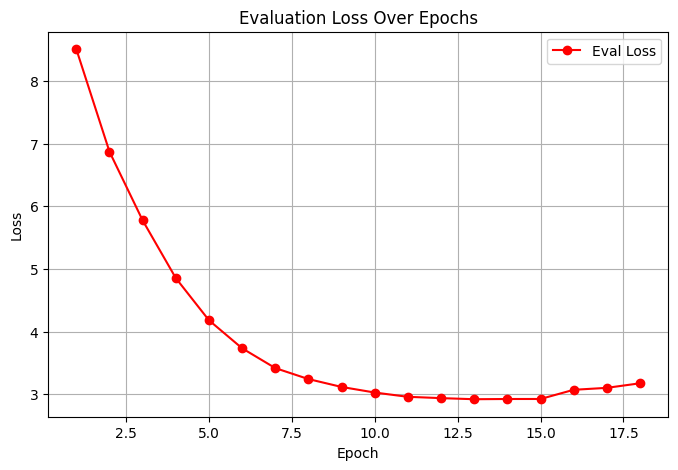

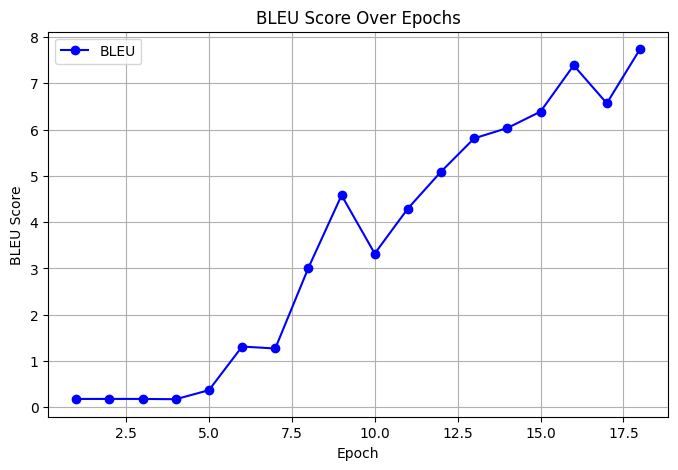

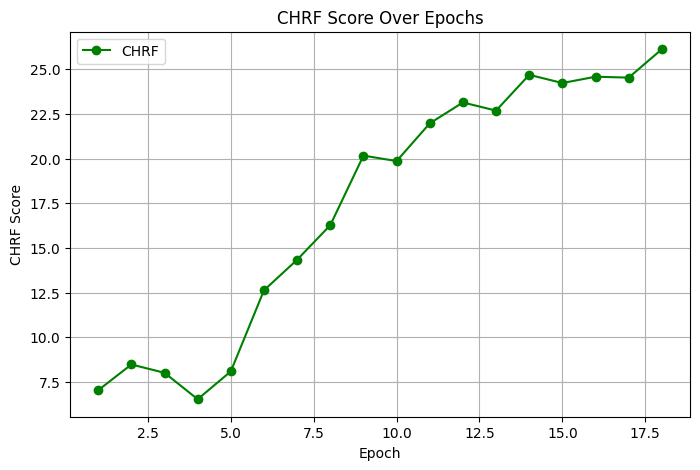

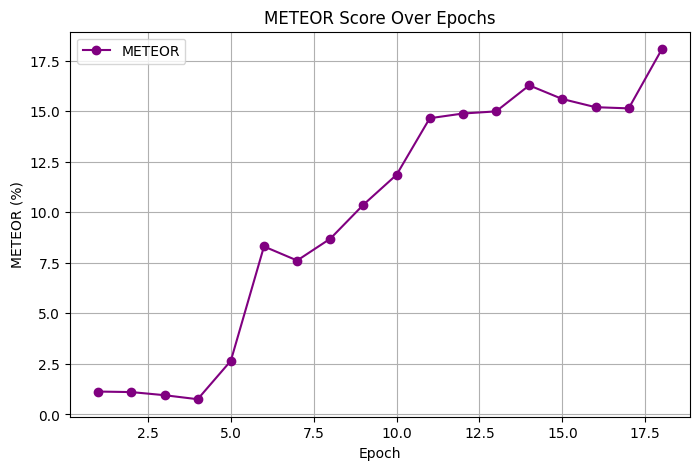

In [ ]:
import json
import matplotlib.pyplot as plt

# (Optional) If you'd like inline plots in Colab:
%matplotlib inline

# Load the metrics_history.json file
with open("metrics_history.json", "r") as f:
    data = json.load(f)

# Extract metrics
epochs = [item["epoch"] for item in data]
eval_loss = [item["eval_loss"] for item in data]
eval_bleu = [item["eval_bleu"] for item in data]
eval_chrf = [item["eval_chrf"] for item in data]

# Some runs might have eval_meteor; handle carefully:
eval_meteor = [item["eval_meteor"] for item in data if "eval_meteor" in item]

# Plot eval_loss
plt.figure(figsize=(8,5))
plt.plot(epochs, eval_loss, marker="o", label="Eval Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Evaluation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Plot BLEU
plt.figure(figsize=(8,5))
plt.plot(epochs, eval_bleu, marker="o", label="BLEU", color="blue")
plt.xlabel("Epoch")
plt.ylabel("BLEU Score")
plt.title("BLEU Score Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Plot CHRF
plt.figure(figsize=(8,5))
plt.plot(epochs, eval_chrf, marker="o", label="CHRF", color="green")
plt.xlabel("Epoch")
plt.ylabel("CHRF Score")
plt.title("CHRF Score Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# (Optional) Plot METEOR if available
if eval_meteor:
    plt.figure(figsize=(8,5))
    plt.plot(epochs[:len(eval_meteor)], eval_meteor, marker="o", label="METEOR", color="purple")
    plt.xlabel("Epoch")
    plt.ylabel("METEOR (%)")
    plt.title("METEOR Score Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()


Test Evaluate

In [ ]:
test_metrics = trainer.evaluate(
    eval_dataset=tokenized_datasets["test"],
    metric_key_prefix="test"
)
print(test_metrics)


NameError: name 'trainer' is not defined

In [ ]:
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast
import torch

model_path = "/content/drive/MyDrive/Translation/saved_models/mbart"
tokenizer = MBart50TokenizerFast.from_pretrained(model_path)
model = MBartForConditionalGeneration.from_pretrained(model_path)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)


MBartForConditionalGeneration(
  (model): MBartModel(
    (shared): MBartScaledWordEmbedding(250054, 1024, padding_idx=1)
    (encoder): MBartEncoder(
      (embed_tokens): MBartScaledWordEmbedding(250054, 1024, padding_idx=1)
      (embed_positions): MBartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x MBartEncoderLayer(
          (self_attn): MBartSdpaAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): ReLU()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
    

In [ ]:
def translate(text, src_lang="en_XX", tgt_lang="xh_ZA"):
    # Adjust these placeholders based on your language codes
    tokenizer.src_lang = src_lang
    inputs = tokenizer([text], return_tensors="pt").to(device)

    forced_bos_id = tokenizer.lang_code_to_id[tgt_lang]

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            forced_bos_token_id=forced_bos_id,
            max_length=128
        )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)


In [ ]:
source_sentence = "male"
juhoansi_output = translate(source_sentence, src_lang="en_XX", tgt_lang="xh_ZA")

print("English:", source_sentence)
print("Ju/'hoansi (xh_ZA):", juhoansi_output)


English: male
Ju/'hoansi (xh_ZA): hanu


In [ ]:
!pip install datasets

In [ ]:
!pip install sacrebleu

In [ ]:
import torch
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast

# Path to your fine-tuned model in Drive
model_path = "/content/drive/MyDrive/Translation/saved_models/mbart"

# Load
tokenizer = MBart50TokenizerFast.from_pretrained(model_path)
model = MBartForConditionalGeneration.from_pretrained(model_path)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Check language codes
print("Available language codes:", tokenizer.lang_code_to_id.keys())

# We'll assume "xh_ZA" is present.
tokenizer.src_lang = "en_XX"
tokenizer.tgt_lang = "xh_ZA"

def translate(text, src_lang="en_XX", tgt_lang="xh_ZA"):
    """
    Translate English -> 'xh_ZA' (placeholder for Ju/'hoansi).
    """
    tokenizer.src_lang = src_lang
    inputs = tokenizer([text], return_tensors="pt").to(device)

    forced_bos_id = tokenizer.lang_code_to_id[tgt_lang]

    with torch.no_grad():
        output = model.generate(
            **inputs,
            forced_bos_token_id=forced_bos_id,
            max_length=128
        )
    return tokenizer.batch_decode(output, skip_special_tokens=True)[0]

# Test a sample
sample_sentences = [
    "We felt lonely because we were far from family.",
    "Education is important to everyone in our community.",
]

for sent in sample_sentences:
    translation = translate(sent)
    print(f"English: {sent}")
    print(f"Ju/'hoansi (xh_ZA) translation: {translation}")
    print("-" * 60)


Available language codes: dict_keys(['ar_AR', 'cs_CZ', 'de_DE', 'en_XX', 'es_XX', 'et_EE', 'fi_FI', 'fr_XX', 'gu_IN', 'hi_IN', 'it_IT', 'ja_XX', 'kk_KZ', 'ko_KR', 'lt_LT', 'lv_LV', 'my_MM', 'ne_NP', 'nl_XX', 'ro_RO', 'ru_RU', 'si_LK', 'tr_TR', 'vi_VN', 'zh_CN', 'af_ZA', 'az_AZ', 'bn_IN', 'fa_IR', 'he_IL', 'hr_HR', 'id_ID', 'ka_GE', 'km_KH', 'mk_MK', 'ml_IN', 'mn_MN', 'mr_IN', 'pl_PL', 'ps_AF', 'pt_XX', 'sv_SE', 'sw_KE', 'ta_IN', 'te_IN', 'th_TH', 'tl_XX', 'uk_UA', 'ur_PK', 'xh_ZA', 'gl_ES', 'sl_SI'])
English: We felt lonely because we were far from family.
Ju/'hoansi (xh_ZA) translation: Mi’m ko ku /xoa /xoa tci /xoa tci /xoa skore.
------------------------------------------------------------
English: Education is important to everyone in our community.
Ju/'hoansi (xh_ZA) translation: E!ha ko ku !gae /xoa ko !gae /xoa ko !gae /xoa.
------------------------------------------------------------


In [ ]:
print("Available language codes:", tokenizer.lang_code_to_id.keys())


Available language codes: dict_keys(['ar_AR', 'cs_CZ', 'de_DE', 'en_XX', 'es_XX', 'et_EE', 'fi_FI', 'fr_XX', 'gu_IN', 'hi_IN', 'it_IT', 'ja_XX', 'kk_KZ', 'ko_KR', 'lt_LT', 'lv_LV', 'my_MM', 'ne_NP', 'nl_XX', 'ro_RO', 'ru_RU', 'si_LK', 'tr_TR', 'vi_VN', 'zh_CN', 'af_ZA', 'az_AZ', 'bn_IN', 'fa_IR', 'he_IL', 'hr_HR', 'id_ID', 'ka_GE', 'km_KH', 'mk_MK', 'ml_IN', 'mn_MN', 'mr_IN', 'pl_PL', 'ps_AF', 'pt_XX', 'sv_SE', 'sw_KE', 'ta_IN', 'te_IN', 'th_TH', 'tl_XX', 'uk_UA', 'ur_PK', 'xh_ZA', 'gl_ES', 'sl_SI'])


In [ ]:
import torch
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast
from sacrebleu import corpus_bleu

# (1) Load your fine-tuned model as shown before
model_path = "/content/drive/MyDrive/Translation/saved_models/mbart"
tokenizer = MBart50TokenizerFast.from_pretrained(model_path)
model = MBartForConditionalGeneration.from_pretrained(model_path)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

tokenizer.src_lang = "en_XX"
tokenizer.tgt_lang = "xh_ZA"

def translate(text, src_lang="en_XX", tgt_lang="xh_ZA"):
    tokenizer.src_lang = src_lang
    inputs = tokenizer([text], return_tensors="pt").to(device)
    forced_bos_id = tokenizer.lang_code_to_id[tgt_lang]

    with torch.no_grad():
        output = model.generate(
            **inputs,
            forced_bos_token_id=forced_bos_id,
            max_length=128
        )
    return tokenizer.batch_decode(output, skip_special_tokens=True)[0]

# (2) Define a small test set with references
test_data = [
    (
        "We felt lonely because we were far from family.",
        "Kham ku tham /a e!ha ko tca zu tci /ing te e zuasi hi ǂxa-a."
    ),
    (
        "Education is important to everyone in our community.",
        "E!ha ko ku !gae /xoa ko !gae /xoa ko !gae /xoa."
    ),
]

# (3) Translate each English sentence
model_translations = [translate(eng) for (eng, _) in test_data]

# (4) Prepare references for BLEU
juhoansi_refs = [ref for (_, ref) in test_data]

# (5) Calculate and print BLEU
bleu_score = corpus_bleu(model_translations, [juhoansi_refs])
print("Model translations:", model_translations)
print("Reference translations:", juhoansi_refs)
print(f"BLEU score: {bleu_score.score:.2f}")


Model translations: ['Mi’m ko ku /xoa /xoa tci /xoa tci /xoa skore.', 'E!ha ko ku !gae /xoa ko !gae /xoa ko !gae /xoa.']
Reference translations: ['Kham ku tham /a e!ha ko tca zu tci /ing te e zuasi hi ǂxa-a.', 'E!ha ko ku !gae /xoa ko !gae /xoa ko !gae /xoa.']
BLEU score: 54.24
